# fashion MNIST  
---  
## Training  
https://www.youtube.com/watch?v=XfYmia3q2Ow&list=PLZbbT5o_s2xrfNyHZsM6ufI0iZENK9xgG&index=26

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
# from torchvision import transforms

torch.set_printoptions(linewidth=120) # display option for output
torch.set_grad_enabled(True) # gradient tracking turned on (default)

In [2]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [3]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        # linear layer == fully connected layer == fc == dense layer
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        # (1) input layer:
        # t = t
        
        # (2) hidden conv layer:
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (3) hidden conv layer:
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (4) hidden linear layer:
        t = t.reshape(-1, 12*4*4)
        # t = t.flatten()
        t = self.fc1(t)
        t = F.relu(t)
        
        # (5) hidden linear layer:
        t = self.fc2(t)
        t = F.relu(t)
        
        # (6) output layer:
        t = self.out(t)
        #t = F.softmax(t, dim=1)
        
        return t

In [4]:
train_set = torchvision.datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [5]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

for epoch in range(5):
    total_loss = 0
    total_correct = 0

    for batch in train_loader:
        images, labels = batch

        preds = network(images)
        loss = F.cross_entropy(preds, labels) # calculating the loss function

        optimizer.zero_grad() # zero out the gradients, because pytorch is actually adding the grads
        loss.backward() # calculating the gradients
        optimizer.step() # update the weight

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(f'epoch: {epoch} total correct: {total_correct} loss: {total_loss:.2f} accuracy {100*total_correct / len(train_set):.2f}%')


epoch: 0 total correct: 47529 loss: 329.37 accuracy 79.22%
epoch: 1 total correct: 51367 loss: 233.32 accuracy 85.61%
epoch: 2 total correct: 52125 loss: 213.33 accuracy 86.88%
epoch: 3 total correct: 52465 loss: 203.19 accuracy 87.44%
epoch: 4 total correct: 52674 loss: 197.16 accuracy 87.79%


---  
## Analyze the results - confusion matrix  
https://www.youtube.com/watch?v=0LhiS6yu2qQ&list=PLZbbT5o_s2xrfNyHZsM6ufI0iZENK9xgG&index=27

In [6]:
len(train_set)

60000

In [7]:
len(train_set.targets)

60000

In [8]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds
        

In [9]:
prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
train_preds = get_all_preds(network, prediction_loader)

In [10]:
train_preds.shape

torch.Size([60000, 10])

In [11]:
print(train_preds.requires_grad)
# train_preds required gradient tracking turned on

True


In [13]:
train_preds.grad

In [14]:
train_preds.grad_fn

In [15]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
    train_preds = get_all_preds(network, prediction_loader)
    # get predictions without gradient tracking

*or*

In [ ]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

In [16]:
print(train_preds.requires_grad)

False


In [17]:
train_preds.grad

In [18]:
train_preds.grad_fn

In [19]:
preds_correct = get_num_correct(train_preds, train_set.targets)

print(f'total correct: {preds_correct}')
print(f'accuracy: {(preds_correct / len(train_set)):.2f}')

total correct: 52372
accuracy: 0.8728666666666667


In [20]:
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [21]:
train_preds.argmax(dim=1)

tensor([9, 0, 0,  ..., 3, 0, 5])

In [26]:
stacked = torch.stack((train_set.targets, train_preds.argmax(dim=1)), dim=1)

In [27]:
stacked.shape

torch.Size([60000, 2])

In [28]:
stacked

tensor([[9, 9],
        [0, 0],
        [0, 0],
        ...,
        [3, 3],
        [0, 0],
        [5, 5]])

In [29]:
stacked[0].tolist()

[9, 9]

In [35]:
conf_t = torch.zeros(10, 10, dtype=torch.int32)
conf_t

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)

In [36]:
for p in stacked:
    target, prediction = p.tolist()
    conf_t[target, prediction] = conf_t[target, prediction] + 1

In [37]:
conf_t

tensor([[5400,   54,  152,  101,   14,    2,  238,    1,   38,    0],
        [   5, 5931,    7,   43,    7,    0,    2,    0,    5,    0],
        [  39,   10, 4572,   72,  918,    2,  367,    1,   19,    0],
        [ 213,  330,   21, 5146,  165,    1,  118,    1,    4,    1],
        [  10,   11,  265,  234, 5021,    0,  440,    3,   16,    0],
        [   0,    0,    5,    0,    0, 5724,    2,  177,    4,   88],
        [1314,   38,  637,  126,  544,    0, 3291,    1,   48,    1],
        [   0,    0,    0,    0,    0,   76,    0, 5833,    0,   91],
        [  21,    3,   34,   25,   10,   29,   43,   17, 5817,    1],
        [   0,    0,    0,    0,    1,   22,    0,  339,    1, 5637]], dtype=torch.int32)

*or*

In [39]:
from sklearn.metrics import confusion_matrix

conf_t = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))
conf_t

array([[5400,   54,  152,  101,   14,    2,  238,    1,   38,    0],
       [   5, 5931,    7,   43,    7,    0,    2,    0,    5,    0],
       [  39,   10, 4572,   72,  918,    2,  367,    1,   19,    0],
       [ 213,  330,   21, 5146,  165,    1,  118,    1,    4,    1],
       [  10,   11,  265,  234, 5021,    0,  440,    3,   16,    0],
       [   0,    0,    5,    0,    0, 5724,    2,  177,    4,   88],
       [1314,   38,  637,  126,  544,    0, 3291,    1,   48,    1],
       [   0,    0,    0,    0,    0,   76,    0, 5833,    0,   91],
       [  21,    3,   34,   25,   10,   29,   43,   17, 5817,    1],
       [   0,    0,    0,    0,    1,   22,    0,  339,    1, 5637]],
      dtype=int64)

In [40]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [41]:
names = ('T-shirt/top', 
         'Trouser',
         'Pullover',
         'Dress',
         'Coat',
         'Sandal',
         'Shirt',
         'Sneaker',
         'Bag',
         'Ankle boot')

Confusion matrix, without normalization
[[5400   54  152  101   14    2  238    1   38    0]
 [   5 5931    7   43    7    0    2    0    5    0]
 [  39   10 4572   72  918    2  367    1   19    0]
 [ 213  330   21 5146  165    1  118    1    4    1]
 [  10   11  265  234 5021    0  440    3   16    0]
 [   0    0    5    0    0 5724    2  177    4   88]
 [1314   38  637  126  544    0 3291    1   48    1]
 [   0    0    0    0    0   76    0 5833    0   91]
 [  21    3   34   25   10   29   43   17 5817    1]
 [   0    0    0    0    1   22    0  339    1 5637]]


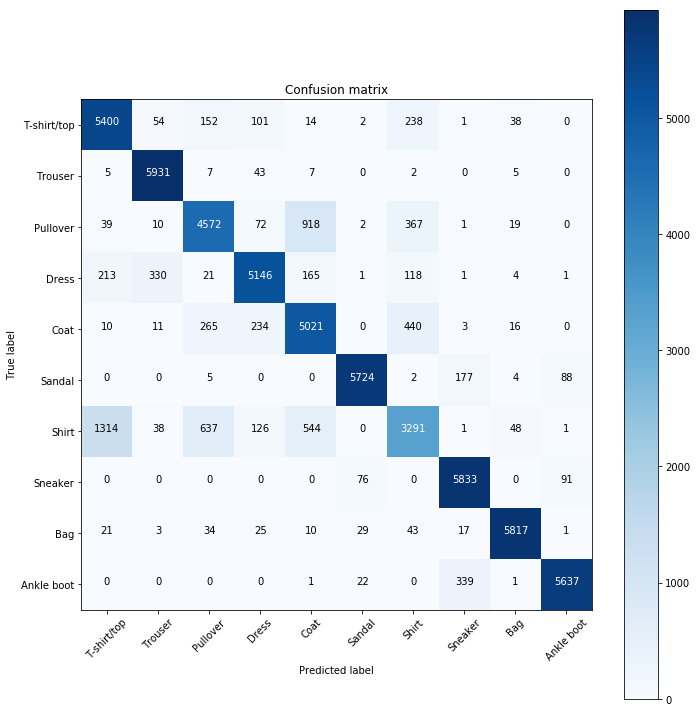

In [42]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(conf_t, names)